In [2]:
include("NTKernel.jl");

In [3]:
# PSUDEO data
g = x -> x+1      # anonymous function g(x)

X = range(0, stop=5, length=10)
X = Matrix(reshape(X, 1, :))
      # reshape, each column vector is read as data point

Y = map(g,X)+0.1*randn(size(X))                 # Map with g(x)

1×10 Matrix{Float64}:
 0.893023  1.50407  2.1074  2.72192  …  4.14996  4.77667  5.34361  6.00169

In [4]:
model_test = Chain(Dense(1=>1,sigmoid),Dense(1=>1))



Chain(
  Dense(1 => 1, σ),                     # 2 parameters
  Dense(1 => 1),                        # 2 parameters
)                   # Total: 4 arrays, 4 parameters, 272 bytes.

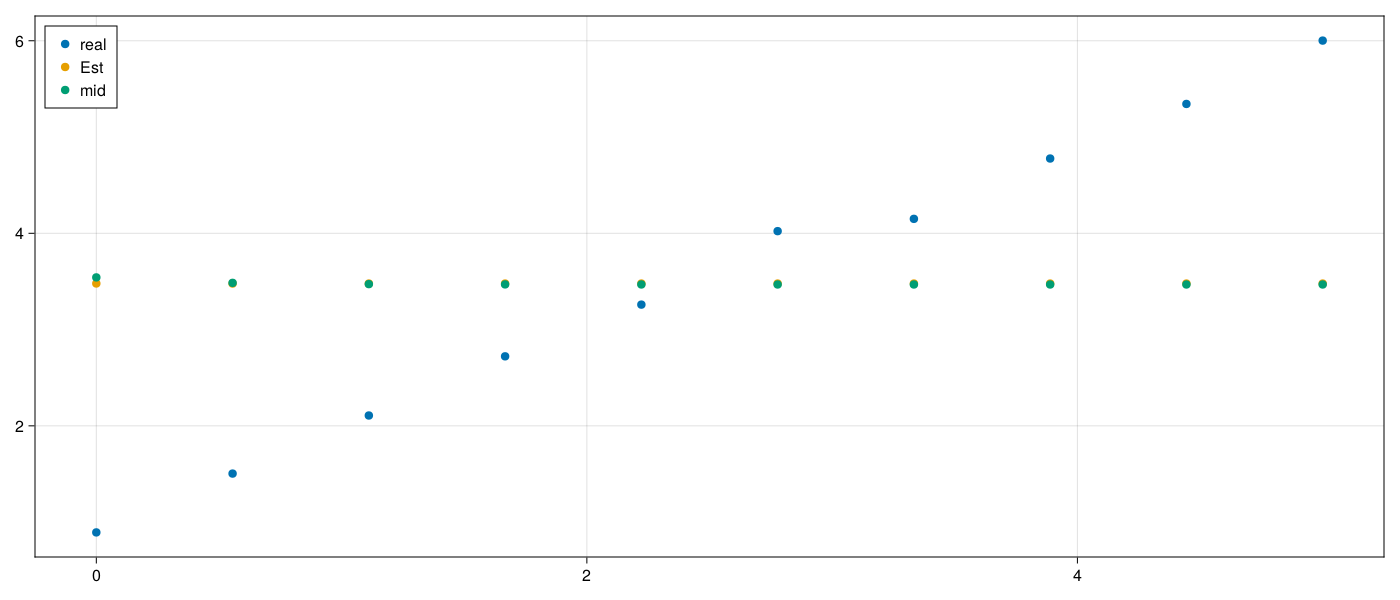

In [6]:
using CairoMakie

fig = Figure(resolution = (1400, 600))
ax1 = Axis(fig[1,1])

s1 = scatter!(ax1,X[:],Y[:],label="real")

data = [(X,Y)]
Nepoch = 10000
opt = Descent(0.2)

loss(model, x, y) = Flux.Losses.mse(model(x),y)
MySnapsLoc = [100] #insert your locations
MySnaps = Vector{Vector}()

for epoch=1:Nepoch
    Flux.train!(loss, model_test, data, opt)
    if epoch in MySnapsLoc
        push!(MySnaps, map_model(model_test,X))
    end
end
Y_fit = map_model(model_test,X)
s2 = scatter!(ax1,X[:],Y_fit[:],label="Est")
s3 = scatter!(ax1,X[:],MySnaps[1],label="mid")

axislegend(ax1,position=:lt)
fig

In [141]:
# nodes on hidden layer

function create_model(Ni, Nh, No, N, activation)
    layers = [] # Initialize an empty array without specifying the type of elements
    push!(layers, Dense(Ni, N, activation)) # First hidden layer with N nodes and specified activation
    for _ in 2:Nh
        push!(layers, Dense(N, N, activation)) # Additional Nh-1 hidden layers
    end
    push!(layers, Dense(N, No)) # Output layer without specifying an activation function (defaults to identity)
    model = Chain(layers...)|>f64 # Create the model from the layers
    return model
end


Nh_list = [1] 
H_Layers = [1]
models = []
activation = sigmoid

InputDim = 1

models = []
for Nh in 1:length(Nh_list)
    for Layer in 1:length(H_Layers)
        push!(models, create_model(InputDim,H_Layers[Layer],InputDim,Nh_list[Nh],activation))
    end
end

Kernels = []
for model in models
    push!(Kernels, kernel(model, X))
end

Kernels_Norms = []
# Iterate over each kernel and normalize according to your pattern
for i in 1:length(Kernels)
    # Use mod1 to cycle through Nh_list based on i
    # This approach correctly associates each kernel with its Nh value according to your pattern
    Nh_index = mod1(i, length(Nh_list))
    Nh = Nh_list[Nh_index]
    normalized_K = Kernels[i] / sqrt(Nh)
    push!(Kernels_Norms, normalized_K)
end
λ_values = []
for K in Kernels_Norms
    push!(λ_values, eigen(K).values) # Compute eigenvalues for each kernel and store
end


In [1]:
# for i in 1:length(models)
#     display(models[i])
# end



loss(model, x, y) = Flux.Losses.mse(model(x),y)

opt = Descent(1/5)
data = [(X, Y)]
Nepoch=50000

λ_big = []
for λ in λ_values[1]
    if λ > 10^-6
        push!(λ_big,λ)
    end
end
count = length(λ_values[1])
big_count = length(λ_big)

MySnapsLoc = [100] #insert your locations
MySnaps = Vector{Vector}()

for epoch=1:Nepoch
    Flux.train!(loss, models[1], data, opt)
    if epoch in MySnapsLoc
        push!(MySnaps, map_model(models[1],X))
    end
end
Y_fit = map_model(models[1],X)
MySnapsLoc = MySnapsLoc[1]


# display(Y_fit)
# display(MySnaps)
loss_updt = round(loss(models[1],X,Y),digits=3)
λ_values[1] .= abs.(λ_values[1])
λ_values[1] .= sort!(λ_values[1])

UndefVarError: UndefVarError: `Descent` not defined

In [309]:
MySnaps

1-element Vector{Vector}:
 [1.2132423464835083, 1.0199154992559076, 0.8564796544826091, 0.7076679322488912, 0.5599814329555957, 0.4054649214181165, 0.2423740450778934, 0.07326809150016894, -0.09763349686036174, -0.26633197530043756  …  -0.2376703590053178, -0.1477620867750427, -0.046299112687667295, 0.06622217982688319, 0.1893082171136059, 0.32247050814719436, 0.4652274563754346, 0.6171058068703636, 0.7776418009862911, 0.9463820932546336]

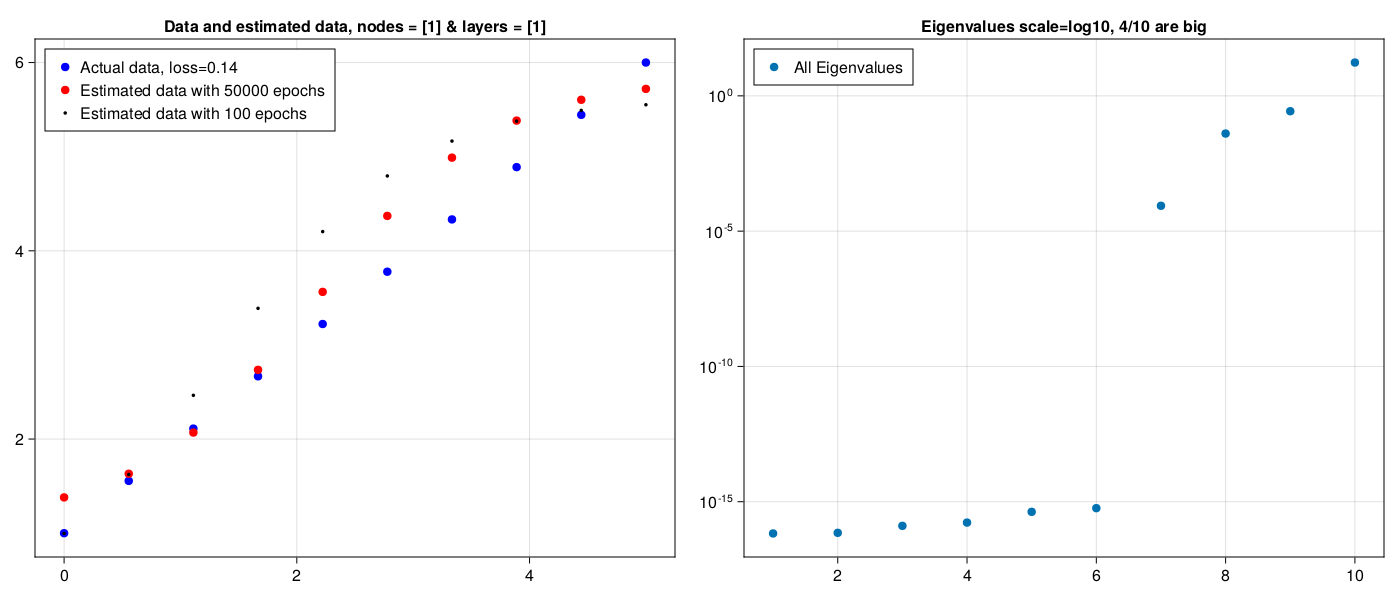

In [168]:
using CairoMakie

fig = Figure(resolution = (1400, 600))
ax1 = Axis(fig[1, 1], title = "Data and estimated data, nodes = $Nh_list & layers = $H_Layers")
ax2 = Axis(fig[1, 2], title = "Eigenvalues scale=log10, $big_count/$count are big",yscale=log10)
s1 = scatter!(ax1, X[:], Y[:], color =:blue, label="Actual data, loss=$loss_updt")
s2 = scatter!(ax1, X[:],Y_fit[:], color =:red, label="Estimated data with $Nepoch epochs")
s3 = scatter!(ax1, X[:],MySnaps[1], color =:black, label="Estimated data with $MySnapsLoc epochs", markersize = 5)
scatter!(ax2,λ_values[1],label=" All Eigenvalues")



# Create a legend for ax1 with the specified scatter plots
axislegend(ax1,position=:lt)
axislegend(ax2,position=:lt)



fig